In [2]:
import warnings
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
# from visualizer import get_local
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

print("tiny experiments")

save_dir = './tiny_imgs/'
os.makedirs(save_dir, exist_ok=True)

tiny experiments


Observation 1

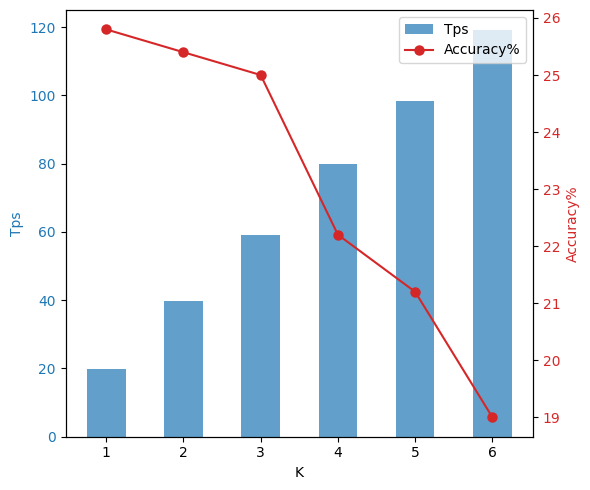

In [18]:
ks = [1, 2, 3, 4, 5, 6]

# score = [52.92, 50.04, 47.16, 44.81, 42.38, 41.55]
# tps = [21.22, 41.33, 61.55, 82.66, 101.85, 122.87]
# title = 'GSM8K gen_len=256'

score = [25.8, 25.4, 25, 22.2, 21.2, 19]
tps = [19.93, 39.83, 59.23, 79.90, 98.50, 119.10]
title = 'Math-500 gen_len=256'

fig, ax2 = plt.subplots(figsize=(6, 5))

# 右轴：Tps（柱状图）
color_tps = 'tab:blue'
ax2.set_ylabel('Tps', color=color_tps)
bar_plot = ax2.bar(ks, tps, width=0.5, color=color_tps, alpha=0.7, label='Tps')
ax2.tick_params(axis='y', labelcolor=color_tps)
ax2.set_xlabel('K')
ax2.set_xticks(ks)

# 左轴：Accuracy（折线，空心点）
ax1 = ax2.twinx()
color_score = 'tab:red'
ax1.set_ylabel('Accuracy%', color=color_score)
line_plot, = ax1.plot(
    ks, score,
    color=color_score,
    marker='o',
    linestyle='-',
    label='Accuracy%',
    markerfacecolor=color_score,
    markeredgecolor=color_score,
    markeredgewidth=1.5
)
ax1.tick_params(axis='y', labelcolor=color_score)

# plt.title(title)

# 合并图例（使用 ax1 的位置显示）
plots = [bar_plot, line_plot]
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='upper right')

fig.tight_layout()
fig.savefig(f'tiny_imgs/{title}.png', dpi=150, bbox_inches='tight')
# plt.show()